In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

### Data Creation

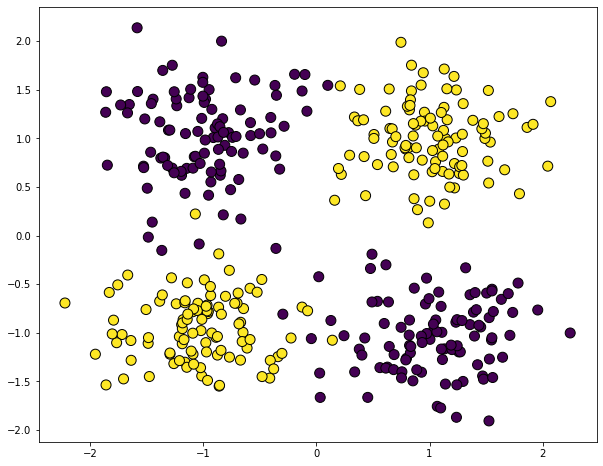

In [2]:
plt.figure(figsize = (10,8))

X = np.random.uniform(-3, 3, size = (100,2));

n1,n2,n3,n4 = 100,100,100,100
n = n1+n2+n3+n4

X1 = np.random.normal([1,1], 0.05, (n1, 2))
X2 = np.random.normal([1,-1], 0.05, (n2, 2))
X3 = np.random.normal([-1,1], 0.05, (n3, 2))
X4 = np.random.normal([-1,-1], 0.05, (n4, 2))

X = np.concatenate((X1,X2,X3,X4))
np.random.shuffle(X)

Y = 1*np.logical_xor(X[:, 0] > 0 , X[:, 1] < 0)
Y[Y==0] = -1

noiseLevel = 0.4
noise = noiseLevel * np.random.randn(n, 2)

X += noise 

plt.scatter(X[:, 0], X[:, 1], s=100, c=Y, edgecolors='k')
plt.show()

In [3]:
df_ = {"X1":X[:,0],
       "X2":X[:,1],
        "Y":Y}

df = pd.DataFrame(df_)
df

,X1,X2,Y
0,-1.231928,1.334136,-1
1,-1.292079,-1.219613,1
2,0.599930,-0.903979,-1
3,-0.946428,1.499844,-1
4,1.054960,-0.867908,-1
...,...,...,...
395,-1.208220,-1.285529,1
396,1.557431,-1.459415,-1
397,-1.665142,-0.406114,1
398,1.551054,-0.569210,-1


In [4]:
X = df.drop("Y",axis = 1)
Y = df["Y"]
number_of_data = X.shape[0]

In [6]:
# INITIALIZING PARAMETERS
def initialize_parameters():
         
    parameters = {
                  "weight1": np.array([[-1.4 ,-1.8],[-1.5,-2.0]]),                
                  "bias1": np.array([-1.5 ,2.0]),
                  "weight2": np.array([2.8, -2.7]),
                  "bias2" : np.array([2.2]) 
                    }
                       
    
    return parameters

In [7]:
# quantized
def tanh_threshold(array):
    
    quantized = np.where(array > 0, 1,-1)
    
    return quantized

In [8]:
# qudratic error
def get_error(y_pred,Y):
    return (np.sum(np.power(y_pred - Y , 2)))/2

### Forward Propagation

In [9]:
def forward_propagation(X,parameters_tanh): # This function returns all neurons outputs by using given data
           
    X_columns = X.to_numpy()[:].T #arranging of X vector
    
    # output of first neuron in hidden layer by using weights and tanh function
    O_1_1 = np.tanh(parameters_tanh["bias1"][0] + np.dot(parameters_tanh["weight1"][0],X_columns))  
    
    # output of second neuron in hidden layer by using weights and tanh function
    O_1_2 = np.tanh(parameters_tanh["bias1"][1] + np.dot(parameters_tanh["weight1"][1],X_columns))
      
    # output of output neuron by using weights and tanh function
    O_2_1 = np.tanh(parameters_tanh["bias2"][0] + np.dot(parameters_tanh["weight2"][0],O_1_1) + np.dot(parameters_tanh["weight2"][1],O_1_2))
    
    y_pred = tanh_threshold(O_2_1) # threshold
    
    correct_list = (y_pred == Y) # comparing with actual results
    
    correct_size = len(correct_list[correct_list == True])
    
    accuracy = correct_size / number_of_data #getting accuracy
    
    error = get_error(y_pred, Y) #getting quadratic error
    
    return accuracy, error, O_1_1, O_1_2, O_2_1

In [10]:
def backward_propagation(parameters_tanh, learning_rate, O_1_1, O_1_2, O_2_1):
    
    O_ = np.dot((O_2_1 - Y),(1 - np.power(O_2_1 , 2)))
    
    #arranging X vectors
    X_1 = X.iloc[:,0].to_numpy().reshape((X.shape[0],1)) 
    
    X_2 = X.iloc[:,1].to_numpy().reshape((X.shape[0],1))
    
    #updating weights
    w_2_0_1 = parameters_tanh["bias2"][0] - ((learning_rate * O_) / number_of_data)
    
    w_2_1_1 = parameters_tanh["weight2"][0] - ((learning_rate * np.dot(O_, O_1_1)) / number_of_data)
    
    w_2_1_2 = parameters_tanh["weight2"][1] - ((learning_rate * np.dot(O_, O_1_2))/number_of_data)
    
    w_1_0_1 = parameters_tanh["bias1"][0] - ((learning_rate *  np.dot((O_ * parameters_tanh["weight2"][0]), 
                                                                (1 - np.power(O_1_1 , 2))))/number_of_data)                
        
   
    w_1_0_2 = parameters_tanh["bias1"][1] - ((learning_rate * np.dot(O_ * parameters_tanh["weight2"][1], 
                                                            (1 - np.power(O_2_1 , 2))))/number_of_data)

    
    w_1_1_1 = parameters_tanh["weight1"][0,0] - ((learning_rate * np.dot(O_ * parameters_tanh["weight2"][0], 
                                                  np.dot((1 - np.power(O_1_1 , 2)) , X_1))) /number_of_data)                   
        
    
    w_1_1_2 = parameters_tanh["weight1"][0,1] - ((learning_rate * np.dot(O_ * parameters_tanh["weight2"][1], 
                                                  np.dot((1 - np.power(O_1_2 , 2)) , X_1))) /number_of_data)                                     
        
    
    w_1_2_1 = parameters_tanh["weight1"][1,0] - ((learning_rate * np.dot(O_ * parameters_tanh["weight2"][0], 
                                                np.dot((1 - np.power(O_1_1 , 2)) , X_2))) / number_of_data)                                          
    
    
    w_1_2_2 = parameters_tanh["weight1"][1,1] - ((learning_rate * np.dot(O_ * parameters_tanh["weight2"][1], 
                                                 np.dot((1 - np.power(O_1_2 , 2)) , X_2)))/number_of_data)
                                                                
    new_parameters = {
                  "weight1": np.array([[w_1_1_1[0], w_1_2_1[0]], [w_1_1_2[0] , w_1_2_2[0]] ]),                
                  "bias1": np.array([w_1_0_1[0] , w_1_0_2[0]]),
                  "weight2": np.array([w_2_1_1[0] , w_2_1_2[0]]),
                  "bias2" : np.array([w_2_0_1])
                     }
                     
    return new_parameters

In [12]:
#train our network

number_of_epoch = 100
    
learning_rate = 0.05

parameters_tanh = initialize_parameters()

accuracy_network = 0
    
for i in range(1,number_of_epoch + 1):
        
    accuracy, error, O_1_1, O_1_2, O_2_1  = forward_propagation(X,parameters_tanh)
        
    print("Epoch Number = %i,Error = %.2f ,Accuracy: %.3f " %(i, error,accuracy))
        
    accuracy_network = accuracy
        
    parameters_tanh = backward_propagation(parameters_tanh, learning_rate, O_1_1, O_1_2, O_2_1)

Epoch Number = 1,Error = 64.00 ,Accuracy: 0.920 
Epoch Number = 2,Error = 58.00 ,Accuracy: 0.927 
Epoch Number = 3,Error = 70.00 ,Accuracy: 0.912 
Epoch Number = 4,Error = 58.00 ,Accuracy: 0.927 
Epoch Number = 5,Error = 72.00 ,Accuracy: 0.910 
Epoch Number = 6,Error = 60.00 ,Accuracy: 0.925 
Epoch Number = 7,Error = 66.00 ,Accuracy: 0.917 
Epoch Number = 8,Error = 64.00 ,Accuracy: 0.920 
Epoch Number = 9,Error = 66.00 ,Accuracy: 0.917 
Epoch Number = 10,Error = 64.00 ,Accuracy: 0.920 
Epoch Number = 11,Error = 68.00 ,Accuracy: 0.915 
Epoch Number = 12,Error = 62.00 ,Accuracy: 0.922 
Epoch Number = 13,Error = 68.00 ,Accuracy: 0.915 
Epoch Number = 14,Error = 62.00 ,Accuracy: 0.922 
Epoch Number = 15,Error = 68.00 ,Accuracy: 0.915 
Epoch Number = 16,Error = 62.00 ,Accuracy: 0.922 
Epoch Number = 17,Error = 68.00 ,Accuracy: 0.915 
Epoch Number = 18,Error = 62.00 ,Accuracy: 0.922 
Epoch Number = 19,Error = 68.00 ,Accuracy: 0.915 
Epoch Number = 20,Error = 62.00 ,Accuracy: 0.922 
Epoch Num

## SCIKIT-LEARN

In [38]:
clf = MLPClassifier(solver = 'sgd',learning_rate='constant',learning_rate_init=learning_rate,max_iter=number_of_epoch, activation='tanh',hidden_layer_sizes=(2,))

clf.fit(X,Y)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(2,), learning_rate='constant',
              learning_rate_init=0.05, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [39]:
y_pred_sckt = clf.predict(X)
accuracy_sckt = accuracy_score(Y,tanh_threshold(y_pred_sckt))

## COMPARISON

In [40]:
print("Accuracy of network:",accuracy_network)
print("Accuracy with scikit learn:" , accuracy_sckt)

Accuracy of network: 0.9225
Accuracy with scikit learn: 0.93


In [41]:
print("Weights in first layer(scikitlearn): " + str(clf.coefs_[0][0]) + str(clf.coefs_[0][1]))
print("Weights in first layer(our network): " + str(parameters_tanh["weight1"][0]) + str(parameters_tanh["weight1"][1]))

Weights in first layer(scikitlearn): [-1.43846462 -1.86347645][-1.42747188 -1.89838804]
Weights in first layer(our network): [-1.59791504 -1.85386326][-1.30125538 -1.76271051]


In [42]:
print("Weights in second layer(scikitlearn): " + str(clf.coefs_[1][0]) + " " + str(clf.coefs_[1][1]))
print("Weights in second layer(our network): " + str([parameters_tanh["weight2"][0]]) + " "+str([parameters_tanh["weight2"][1]]))

Weights in second layer(scikitlearn): [2.7779827] [-2.75406747]
Weights in second layer(our network): [2.8007616184256436] [-2.7003466505408324]


In [43]:
print("Bias Terms in first layer(scikitlearn): " + str(clf.intercepts_[0]))
print("Bias Terms in first layer(our network): " + str(parameters_tanh["bias1"]))

Bias Terms in first layer(scikitlearn): [-1.41183287  2.04166327]
Bias Terms in first layer(our network): [-1.49941843  2.00003941]


In [44]:
print("Bias Terms in output neuron(scikitlearn): " + str(clf.intercepts_[1]))
print("Bias Terms in output neuron(our network): " + str(parameters_tanh["bias2"]))

Bias Terms in output neuron(scikitlearn): [2.20263153]
Bias Terms in output neuron(our network): [2.1993513]
